# **Regression Project (Store Sales -- Time Series Forecasting)**

## **Business Understanding**

### **introduction**


Welcome to a compelling journey into the realm of time series forecasting! In this project, we embark on the intriguing challenge of predicting store sales using data from Corporation Favorita, a prominent grocery retailer based in Ecuador. As we delve into the intricacies of this task, our primary objective is to construct a robust model capable of accurately predicting the unit sales for a myriad of items across various Favorita stores.

The foundation of our predictive prowess lies in a diverse array of data points, including dates, store and product details, information about promotional activities, and, crucially, the corresponding sales figures. Our dataset is enriched with supplementary files containing additional information, providing a wealth of insights that can be harnessed to enhance the predictive capabilities of our models.

Join us as we navigate through the nuances of this time series forecasting problem, unraveling patterns, and leveraging comprehensive data to build a model that not only forecasts sales accurately but also unveils the underlying dynamics of retail operations within Corporation Favorita. Your journey begins here, where data science meets the world of retail, promising a captivating exploration of analytics and forecasting.








# **Project Description**

## **Title:  Enhancing Store Sales Forecasting for Corporation Favorita** ##

## **Objective:** ##

This project aims to develop a robust time series forecasting model to predict store sales for Corporation Favorita, a leading grocery retailer in Ecuador. By leveraging advanced analytics, the goal is to provide accurate predictions for unit sales across a diverse range of items in different Favorita stores. The insights derived from this forecasting model will empower Favorita with data-driven decision-making capabilities, optimizing inventory management, promotional strategies, and overall business performance.

## **Scope:** ##

The project encompasses the exploration and analysis of a comprehensive dataset, including dates, store details, product information, promotional activities, and sales figures. Supplementary files containing additional information will be utilized to enhance the predictive capabilities of the models.

## **Data Field Information:** ##

**1. train.csv:**
Description: The training data, comprising a time series of features including store_nbr, family, onpromotion, and the target variable sales.
Data Fields:
store_nbr: Identifies the store where products are sold.
family: Identifies the type of product sold.
sales: Total sales for a product family at a specific store on a given date.
onpromotion: Total number of items in a product family that were being promoted at a store on a given date.

**2. test.csv:**
Description: The test data, having the same features as the training data. Used to predict target sales for the 15 days after the last date in the training data.
Data Fields:
Same as the train.csv data fields.

**3. transaction.csv:**
Description: Contains information about transactions made on specific dates.
Data Fields:
date: Date of the transaction.
store_nbr: Identifies the store where the transaction occurred.
Additional details about the transaction.

**4. sample_submission.csv:**
Description: A sample submission file in the correct format.

**5. stores.csv:**
Description: Store metadata, including city, state, type, and cluster. Cluster represents a grouping of similar stores.
Data Fields:
store_nbr: Identifies the store.
city: City where the store is located.
state: State where the store is located.
type: Type of the store.
cluster: Grouping of similar stores.

**6. oil.csv:**
Description: Daily oil prices, including values during both the train and test data timeframes. Given Ecuador's dependency on oil, its economical health is highly vulnerable to shocks in oil prices.

**7. holidays_events.csv:**
Description: Holidays and Events metadata, including information about transferred holidays.
Data Fields:
date: Date of the holiday or event.
Additional metadata about the holiday or event.

## **The Hypothesis**

### **Null Hypothesis (H0):** There is no significant difference in sales between promoted and non-promoted items.

### **Alternative Hypothesis (H1):** Items that are promoted have significantly higher sales compared to non-promoted items.

## **The Analytical Questions**

1. Do items on promotion sell more, and is this difference statistically significant?
2.  Are sales different between different types of stores?
3. Does the daily oil price correlate with overall sales?
4. Do sales change significantly during holidays?
5. Do some products consistently sell more during certain seasons?
6. Do sales patterns vary depending on the day of the week?

## 1. Importing the relevant libraries and modules

In [1]:
import pyodbc
from dotenv import dotenv_values
import re
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing visualization modules
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import plotly.express as px 

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

In [4]:
# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("servername")
database = environment_variables.get("databasename")
username = environment_variables.get("user")
password = environment_variables.get("password")
table = environment_variables.get("tablename")

# Construct the connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"


In [5]:
# Establish a connection to the database using the provided connection string.
connection= pyodbc.connect(connection_string)

# 2. Loading data

In [6]:

# SQL query to fetch data from 'dbo.oil' table
query = "Select * from dbo.oil"

 
# Read data from the SQL query result
df_oil = pd.read_sql(query, connection)
 
 # Display the first few rows of the DataFrame
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [7]:

# SQL query to fetch data from 'dbo.holidays_events' table
query = "Select * from dbo.holidays_events"

# Read data from the SQL query result
df_holidays_events = pd.read_sql(query, connection)
 # Display the first few rows of the DataFrame
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:

# SQL query to fetch data from 'dbo_stores' table
query = "Select * from dbo.stores"

 
# Read data from the SQL query result
df_stores = pd.read_sql(query, connection)
 
 # Display the first few rows of the DataFrame
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
df_test  = pd.read_csv("Data/test.csv")

In [10]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [11]:
# Reading Data from Github
df_train = pd.read_csv("Data/train.csv")

In [12]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [13]:
df_transaction = pd.read_csv("Data/transactions.csv")

In [14]:
df_transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


## 3. Exploratory Data Analysis

In [15]:
# Get the column information of each dataset
# Function to display column information of the datasets
def show_column_info(dataset_name, dataset):
    print(f"Data types for the {dataset_name} dataset:")
    print(dataset.info())
    print('==='*14)

In [16]:
# Column information of the train and test columns
show_column_info('Train', df_train)
print()
show_column_info('Test', df_test)

Data types for the Train dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None

Data types for the Test dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None


Train Dataset:

Number of Entries: 3,000,888

Columns:

1. id: Unique identifier for each entry, stored as an integer (int64).
2. date: Date of the recorded data, stored as an object. Considering converting to datetime type for date-related operations.
3. store_nbr: Store number, stored as an integer (int64).
4. family: Product family category, stored as an object (likely a string).
5. sales: Sales data, recorded as a float (float64).
6. onpromotion: Binary indicator (0 or 1) for whether the product is on promotion, stored as an integer (int64).



Test Dataset:

Number of Entries: 28,512

Columns:

1. id: Unique identifier for each entry, stored as an integer (int64).
2. date: Date of the recorded data, stored as an object. Consider converting to datetime type for date-related operations.
3. store_nbr: Store number, stored as an integer (int64).
4. family: Product family category, stored as an object (likely a string).
5. onpromotion: Binary indicator (0 or 1) for whether the product is on promotion, stored as an integer (int64).



NOTE:- These datasets seem suitable for tasks related to sales forecasting or analysis, with information about sales, store numbers, product families, and promotion status. If time-series analysis is involved, considering converting the 'date' column to datetime type.

In [17]:
# Column information of the other datasets
show_column_info('Holiday events', df_holidays_events)
print()
show_column_info('Oil', df_oil)
print()
show_column_info('Stores', df_stores)
print()
show_column_info('Transactions', df_transaction)

Data types for the Holiday events dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None

Data types for the Oil dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None

Data types for the Stores dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Dat

**Holiday Events Dataset:**

Number of Entries: 350

Columns:

1. date: Date of the holiday event, stored as an object (likely a string).
2. type: Type of holiday, stored as an object.
3. locale: Locale information, stored as an object.
4. locale_name: Name of the locale, stored as an object.
5. description: Description of the holiday event, stored as an object.
6. transferred: Boolean indicator (True/False) representing whether the holiday was transferred, stored as a boolean.

**Oil Dataset:**

Number of Entries: 1218

Columns:

1. date: Date of the oil data, stored as an object (likely a string).
2. dcoilwtico: WTI (West Texas Intermediate) crude oil price, stored as a float.

**Stores Dataset:**

Number of Entries: 54

Columns:

1. store_nbr: Store number, stored as an integer (int64).
2. city: City where the store is located, stored as an object.
3. state: State where the store is located, stored as an object.
4. type: Type of store, stored as an object.
5. cluster: Cluster identifier, stored as an integer (int64).


**Transactions Dataset:**

Number of Entries: 83,488

Columns:

1. date: Date of the transaction, stored as an object (likely a string).
2. store_nbr: Store number, stored as an integer (int64).
3. transactions: Number of transactions, stored as an integer (int64).


These datasets contain information related to holidays, oil prices, stores, and transactions, each with its own set of columns and data types. When working with date-related information, considering converting the 'date' columns to datetime type for time-series analysis or other date-based operations.

### Transforming the 'date' column to datetime format

In [18]:
# Converting the 'date' column in the datasets to datetime format
# Train dataset
df_train['date'] = pd.to_datetime(df_train['date'])

# Test dataset
df_test['date'] = pd.to_datetime(df_test['date'])

# Holiday Events dataset
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])

# Oil dataset
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Transactions dataset
df_transaction['date'] = pd.to_datetime(df_transaction['date'])

In [19]:
# Confirm the data type of the 'date' column after transformation
print('Date Column Data Type After Transformation:') 
print('==='*14)
print("Train dataset:", df_train['date'].dtype)
print("Test dataset:", df_test['date'].dtype)
print("Holiday Events dataset:", df_holidays_events['date'].dtype)
print("Oil dataset:", df_oil['date'].dtype)
print("Transactions dataset:", df_transaction['date'].dtype)

Date Column Data Type After Transformation:
Train dataset: datetime64[ns]
Test dataset: datetime64[ns]
Holiday Events dataset: datetime64[ns]
Oil dataset: datetime64[ns]
Transactions dataset: datetime64[ns]


In [20]:
# Checking for the summary statistics of the datasets 
datasets = {'train': df_train, 'test': df_test, 'holiday events': df_holidays_events, 'oil': df_oil, 'stores':df_stores, 'transactions': df_transaction}
for name, data in datasets.items():
    print(f"{name.capitalize()} dataset summary statistics:")
    print('---'*15)
    print(data.describe())
    print('==='*20)
    print()

Train dataset summary statistics:
---------------------------------------------


                 id                           date     store_nbr  \
count  3.000888e+06                        3000888  3.000888e+06   
mean   1.500444e+06  2015-04-24 08:27:04.703088384  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.502218e+05            2014-02-26 18:00:00  1.400000e+01   
50%    1.500444e+06            2015-04-24 12:00:00  2.750000e+01   
75%    2.250665e+06            2016-06-19 06:00:00  4.100000e+01   
max    3.000887e+06            2017-08-15 00:00:00  5.400000e+01   
std    8.662819e+05                            NaN  1.558579e+01   

              sales   onpromotion  
count  3.000888e+06  3.000888e+06  
mean   3.577757e+02  2.602770e+00  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  
50%    1.100000e+01  0.000000e+00  
75%    1.958473e+02  0.000000e+00  
max    1.247170e+05  7.410000e+02  
std    1.101998e+03  1.221888e+01  

Test dataset summary statistics:
-----------------------------

In [21]:
# Check for missing values in the datasets
datasets = {'train': df_train, 'test': df_test, 'holiday events': df_holidays_events, 'oil': df_oil, 'stores': df_stores, 'transactions': df_transaction, }

def show_missing_values(datasets):
    for name, data in datasets.items():
        print(f"Missing values in the {name.capitalize()} dataset:")
        print(data.isnull().sum())
        print('===' * 18)
        print()

show_missing_values(datasets)

Missing values in the Train dataset:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing values in the Test dataset:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Missing values in the Holiday events dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Missing values in the Oil dataset:
date           0
dcoilwtico    43
dtype: int64

Missing values in the Stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Missing values in the Transactions dataset:
date            0
store_nbr       0
transactions    0
dtype: int64



In [22]:
# Visualizing the 'dcoilwtico' column to Identify a Strategy for Handling Missing Values
fig = px.line(df_oil, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [23]:
# use missing values with backfill
df_oil = pd.DataFrame(df_oil)
df_oil = df_oil.bfill()

In [24]:
df_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [25]:
# Visualizing the 'dcoilwtico' after filling with backfill
fig = px.line(df_oil, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Merging The Train Dataset with the Stores, Transactions, Holiday Events and Oil Dataset

In [26]:
# Merging the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_df with stores_df based on 'store_nbr' column
merged_df1 = df_train.merge(df_stores, on='store_nbr', how='inner')

# Merge merged_df1 with transactions_df based on 'date' and 'store_nbr' columns
merged_df2 = merged_df1.merge(df_transaction, on=['date', 'store_nbr'], how='inner')

# Merge merged_df2 with holidays_events_df based on 'date' column
merged_df3 = merged_df2.merge(df_holidays_events, on='date', how='inner')

# Merge merged_df3 with oil_df based on 'date' column
merged_df = merged_df3.merge(df_oil, on='date', how='inner')

# View the first five rows of the merged dataset
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


The use of an inner merge in this time series forecasting project for corporation Favorita helps to ensure data consistency, avoid missing values, and focus on the relevant data for accurate predictions.

An inner merge type retains only the rows with matching values in the specified columns. In the context of time series forecasting, it allows us to merge datasets based on a common time index or timestamp. By performing an inner merge, we ensure that only the rows with corresponding timestamps in both datasets are included in the merged result. This is important for time series forecasting because you want to align the data from different sources based on their timestamps to build a consistent and accurate forecasting model.

With an inner merge, you eliminate any non-matching timestamps, which may not be useful for forecasting and could introduce inconsistencies in the data. By focusing on the intersection of the datasets, we can create a merged dataset that contains the necessary information for accurate time series forecasting.


In [27]:
# Check the column information of the merged dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   type_x        322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  type_y        322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

The merged dataset after merging the train dataset with additional datasets contains 322,047 rows and 16 columns. Two columns have been renamed as a result of the merging, type_x and type_y.

In [28]:
# Check the unique values of the two unknown columns
print("Unique values of 'type_x':")
print(merged_df['type_x'].unique())
print()
print("Unique values of 'type_y':")
print(merged_df['type_y'].unique())

Unique values of 'type_x':
['D' 'C' 'B' 'E' 'A']

Unique values of 'type_y':
['Holiday' 'Additional' 'Transfer' 'Event' 'Bridge']


In [29]:
# Renaming the columns with the approapriate names
merged_df = merged_df.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [30]:
# Generate summary statistics and transpose the rows and columns of the resultant DataFrame.
# Transposing flips the DataFrame (the rows become columns and the columns become rows) for better readability
merged_df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,322047.0,1682979.459576,561.0,1010616.5,1842406.0,2209555.5,3000887.0,786249.257767
date,322047,2015-08-04 23:49:57.971103488,2013-01-01 00:00:00,2014-07-23 00:00:00,2015-11-02 00:00:00,2016-05-27 00:00:00,2017-08-15 00:00:00,NaN
store_nbr,322047.0,26.994672,1.0,13.0,27.0,40.0,54.0,15.595174
sales,322047.0,406.383452,0.0,1.0,19.0,241.260505,124717.0,1246.88124
onpromotion,322047.0,3.727136,0.0,0.0,0.0,1.0,716.0,15.512095
cluster,322047.0,8.531202,1.0,4.0,9.0,13.0,17.0,4.713809
transactions,322047.0,1734.11784,54.0,1030.0,1409.0,2148.0,8359.0,1050.335018
dcoilwtico,322047.0,63.636381,27.959999,44.880001,51.98,94.089996,107.949997,24.855753


In [31]:
# Check for missing values in the merged datasets
missing_values = merged_df.isnull().sum()
missing_values

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

In [32]:
# Check for duplicate values in the merged dataset
duplicate_rows_merged = merged_df.duplicated()
duplicate_rows_merged.sum()

0

In [34]:
# Check for duplicate values in the test dataset
duplicate_rows_test = df_test.duplicated()
duplicate_rows_test.sum()

0

In [35]:
merged_df.to_csv('Data/Visualization_Data.csv', index=False)
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [36]:
# Create A Copy of The Merged Dataset
merged_df_copy = merged_df.copy()
merged_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   store_type    322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  holiday_type  322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

## Univariate, Multivariate and Bivariate Analysis

### Univariate Analysis

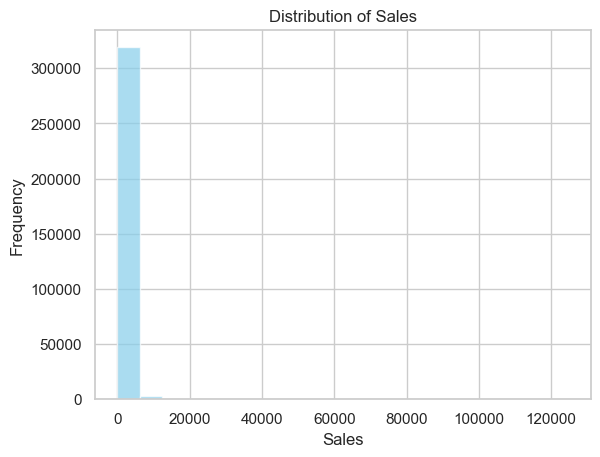

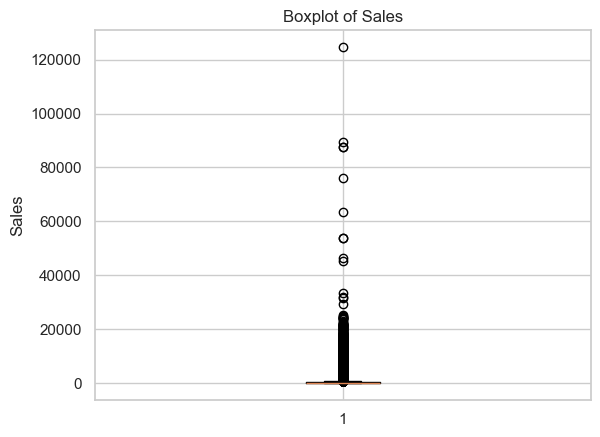

In [53]:
# Histogram
plt.hist(merged_df['sales'], bins=20, color='skyblue', alpha=0.7)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.show()

# Boxplot
plt.boxplot(merged_df['sales'])
plt.ylabel('Sales')
plt.title('Boxplot of Sales')
plt.show()